In [1]:
using CSV, DataFrames, Dates
using PyCall
using CairoMakie
using StatsBase
using DataStructures

@pyimport powerlaw as powlaw
so = pyimport("scipy.optimize")

# fit_tsallis = pyeval("""lambda fit: lambda a, b, c, d: fit(a, b, c, d)""")
# @. tsallis_ccdf(x, α, λ, c) = c*((1+x/(λ))^(-α))

fit_powerlaw = pyeval("""lambda fit: lambda a, b, c: fit(a, b, c)""")
@. powerlaw(x, α, b) = b*((x)^(-α))

powerlaw (generic function with 1 method)

In [2]:
data_in_question = "hourly_sea_level"
datetime = "datetime"
variable = "sea_level"

mkpath("./results_article_plots/")

"./results_article_plots"

In [3]:
delta = 10
period = "1905_2023"
wt_df = CSV.read("./$(variable)/wt_$(period)/wt_$(variable)_delta_$(delta).csv", DataFrame)
wt = wt_df[!,:wt];

In [4]:
function r_squared(x, y, popt_powerlaw)
    y_fit = powerlaw(x,popt_powerlaw[1],popt_powerlaw[2])
    y_mean = mean(y)

    SSres = sum((y .- y_fit).^2)
    SStot = sum((y .- y_mean).^2)

    return (1- SSres/SStot)
end

r_squared (generic function with 1 method)

## Normal hist, normal bins

In [5]:
function plot_hist(nb, data)
    set_theme!(Theme(fonts=(; regular="CMU Serif")))

    markers=[:utriangle, :diamond, :circle, :rect]
    colors=[:lightblue, :lightgreen, :lightsalmon, :orchid]
    line_colors=[:midnightblue, :green, :darkred, :purple]
    i=1

    ########################################### ALL
    # CCDF of all data scattered 
    fig = Figure(resolution = (700, 600), font= "CMU Serif") 
    ax1 = Axis(fig[1,1], xlabel = L"hours", ylabel = L"P", xscale=log10, yscale=log10, ylabelsize = 28,
        xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
        xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)
        
    hist!(data, bins=nb)

    return fig
end

plot_hist (generic function with 1 method)

In [6]:
function make_hist(data, nb)
    h = StatsBase.fit(Histogram, data, nbins=nb)

    y = h.weights

    x_edges = collect(h.edges[1])
    x = [(x_edges[i+1] + x_edges[i])/2 for i in 1:length(x_edges)-1];

    to_del = []
    for i in eachindex(y)
        if y[i] == 0
            push!(to_del, i)
        end
    end

    deleteat!(y, to_del)
    deleteat!(x, to_del);

    return(x,y)
end

make_hist (generic function with 1 method)

In [7]:
function plot_hist_fit(data, nb)
    delta=10

    x, y = make_hist(data, nb)

    y = y ./ sum(y)
    
    x_fit = x[2:end]
    y_fit = y[2:end]


    popt_powerlaw, pcov_powerlaw = so.curve_fit(fit_powerlaw((x, α, b)->powerlaw(x, α, b)), x_fit, y_fit, bounds=(0, Inf), maxfev=3000)

    alpha_bin = round(popt_powerlaw[1], digits=3)
    b_bin = round(popt_powerlaw[2], digits=3)
    println("alpha= ", popt_powerlaw[1],"b= ", popt_powerlaw[2])

    r_sq = round(r_squared(x_fit, y_fit, popt_powerlaw),digits=3)

    set_theme!(Theme(fonts=(; regular="CMU Serif")))

    markers=[:utriangle, :diamond, :circle, :rect]
    colors=[:lightblue, :lightgreen, :lightsalmon, :orchid]
    line_colors=[:midnightblue, :green, :darkred, :purple]
    i=1

    ########################################### ALL
    # CCDF of all data scattered 
    fig = Figure(resolution = (700, 600), font= "CMU Serif") 
    ax1 = Axis(fig[1,1], xlabel = L"k\, \mathrm{[hours]}", ylabel = L"P_k",  ylabelsize = 28, xscale=log10, yscale=log10,
        xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
        xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)
        
    sc1 = scatter!(ax1, x, y,
        color=(colors[i], 0.8), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)

    cut_x=[]
    cut_y=[]
    y_fit = powerlaw(x,popt_powerlaw[1],popt_powerlaw[2])
    for i in eachindex(y)
        if y[i] <= 1
            cut_x = x[2:i+43]
            cut_y = y_fit[2:i+43]
            break
        end
    end
    lines!(ax1, cut_x, cut_y, label= L"\alpha=%$(alpha_bin), \, R^2=%$(r_sq)",
        color=(line_colors[i], 0.7), linewidth=3)


    axislegend(ax1, [sc1], [L"\delta=%$(delta) \, \mathrm{[cm]}"], L"\text{Normal binning}", position = :rt, backgroundcolor = (:grey90, 0.25), labelsize=20, titlesize=20);

    axislegend(ax1, position = :lb, backgroundcolor = (:grey90, 0.25), labelsize=18);

    ax1.xticks = ([10^(0),10^(1),10^(2),10^(3) ,10^(4), 10^(5), 10^(6)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}", L"10^{6}"])
    ax1.yticks = ([10^(-6), 10^(-5),10^(-4),10^(-3),10^(-2),10^(-1), 1, 10^(1), 10^(2), 10^(3), 10^(4) ,10^(5), 10^(6)],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}", L"10^{6}"])


    save("./results_article_plots/wt_$(variable)_delta_$(delta)_bin_normal.png", fig, px_per_unit=5)

    fig
end


    

plot_hist_fit (generic function with 1 method)

alpha= 2.095369131113369b= 45430.10247296456


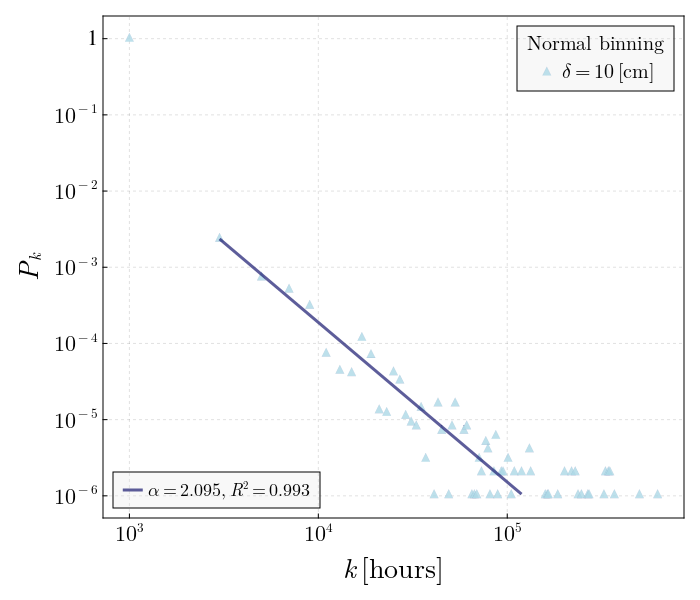

In [47]:
plot_hist_fit(wt, 500)

## Logarithmic binning

In [49]:
log_bins = (10 .^ (range(0,stop= (log10(maximum(wt)+1) / log10(10)),length=60)))
h = StatsBase.fit(Histogram, wt, log_bins)
y = h.weights

x_edges = collect(h.edges[1])
x = [(x_edges[i+1] + x_edges[i])/2 for i in 1:length(x_edges)-1];

to_del = []
for i in eachindex(y)
    if y[i] == 0
        push!(to_del, i)
    end
end

deleteat!(y, to_del)
deleteat!(x, to_del);


In [12]:
# delta=10

# x_fit = x[2:end]
# y_fit = y[2:end]

# normaliza
y = y ./ sum(y)

popt_powerlaw, pcov_powerlaw = so.curve_fit(fit_powerlaw((x, α, b)->powerlaw(x, α, b)), x, y, bounds=(0, Inf), maxfev=3000)

alpha = round(popt_powerlaw[1], digits=3)
b = round(popt_powerlaw[2], digits=3)
println("alpha= ", popt_powerlaw[1],"b= ", popt_powerlaw[2])

r_sq = round(r_squared(x, y, popt_powerlaw),digits=3)

set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :diamond, :circle, :rect]
colors=[:lightblue, :lightgreen, :lightsalmon, :orchid]
line_colors=[:midnightblue, :green, :darkred, :purple]
i=2

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"k\, \mathrm{[hours]}", ylabel = L"P_k",  ylabelsize = 28, xscale=log10, yscale=log10,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)
    
sc1 = scatter!(ax1, x, y,
    color=(colors[i], 0.85), strokewidth=0.05, strokecolor=(line_colors[i], 0.85), marker=markers[i], markersize=12)


# y_fit = powerlaw(x,popt_powerlaw[1],popt_powerlaw[2])
# for i in eachindex(y)
#     if y[i] <= 1
#         cut_x = x[1:i]
#         cut_y = y_fit[1:i]
#         break
#     end
# end
lines!(ax1, x, powerlaw(x,popt_powerlaw[1],popt_powerlaw[2]), label= L"\alpha=%$(alpha), \, R^2=%$(r_sq)",
    color=(line_colors[i], 0.7), linewidth=3)


axislegend(ax1, [sc1], [L"\delta=%$(delta) \, \mathrm{[cm]}"], L"\text{Logarithmic binning}", position = :rt, backgroundcolor = (:grey90, 0.25), labelsize=20, titlesize=20);

axislegend(ax1, position = :lb, backgroundcolor = (:grey90, 0.25), labelsize=18);


ax1.xticks = ([10^(0),10^(1),10^(2),10^(3) ,10^(4), 10^(5), 10^(6)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}", L"10^{6}"])
ax1.yticks = ([10^(-6), 10^(-5),10^(-4),10^(-3),10^(-2),10^(-1), 1, 10^(1), 10^(2), 10^(3), 10^(4) ,10^(5), 10^(6)],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}", L"10^{6}"])

save("./results_article_plots/wt_$(variable)_delta_$(delta)_bin_log.png", fig, px_per_unit=5)

fig

UndefVarError: UndefVarError: `y` not defined

## Rank-freq plot

In [13]:
function plot_rank_frequency_fit(data)
    delta = 10

    rank_freq = sort!(OrderedDict(countmap(data)))
    

    keys = rank_freq.keys
    values = [rank_freq[i] for i in rank_freq.keys]

    delta=10
    
    # x_fit = x[2:end]
    # y_fit = y[2:end]


    popt_powerlaw, pcov_powerlaw = so.curve_fit(fit_powerlaw((x, α, b)->powerlaw(x, α, b)), keys, values, bounds=(0, Inf), maxfev=3000)

    alpha_bin = round(popt_powerlaw[1], digits=3)
    b_bin = round(popt_powerlaw[2], digits=3)
    println("alpha= ", popt_powerlaw[1],"b= ", popt_powerlaw[2])

    r_sq = round(r_squared(keys, values, popt_powerlaw),digits=3)

    set_theme!(Theme(fonts=(; regular="CMU Serif")))

    markers=[:utriangle, :diamond, :circle, :rect]
    colors=[:lightblue, :lightgreen, :lightsalmon, :orchid]
    line_colors=[:midnightblue, :green, :darkred, :purple]
    i=3

    ########################################### ALL
    # CCDF of all data scattered 
    fig = Figure(resolution = (700, 600), font= "CMU Serif") 
    ax1 = Axis(fig[1,1], xlabel = L"k\, \mathrm{[hours]}", ylabel = L"Fr_k",  ylabelsize = 28, xscale=log10, yscale=log10,
        xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
        xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)
        
    sc1 = scatter!(ax1, keys, values,
        color=(colors[i], 0.45), strokewidth=0.05, strokecolor=(line_colors[i], 0.45), marker=markers[i], markersize=12)

    cut_x=[]
    cut_y=[]
    y = powerlaw(keys,popt_powerlaw[1],popt_powerlaw[2])
    for i in eachindex(y)
        if y[i] <= 1
            cut_x = keys[1:i]
            cut_y = y[1:i]
            break
        end
    end
    lines!(ax1, cut_x, cut_y, label= L"\alpha=%$(alpha_bin), \, R^2=%$(r_sq)",
        color=(line_colors[i], 0.7), linewidth=3)


    axislegend(ax1, [sc1], [L"\delta=%$(delta) \, \mathrm{[cm]}"],L"\text{Rank-frequency}", position = :rt, backgroundcolor = (:grey90, 0.25), labelsize=20, titlesize=20);

    axislegend(ax1, position = :lb, backgroundcolor = (:grey90, 0.25), labelsize=18);

    
    ax1.xticks = ([10^(0),10^(1),10^(2),10^(3) ,10^(4), 10^(5), 10^(6)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}", L"10^{6}"])
    ax1.yticks = ([1, 10^(1), 10^(2), 10^(3), 10^(4) ,10^(5), 10^(6)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}", L"10^{6}"])


    save("./results_article_plots/wt_$(variable)_delta_$(delta)_bin_rf.png", fig, px_per_unit=7)

    fig
end


    

plot_rank_frequency_fit (generic function with 1 method)

alpha= 1.1277687612884963b= 246295.35983951797


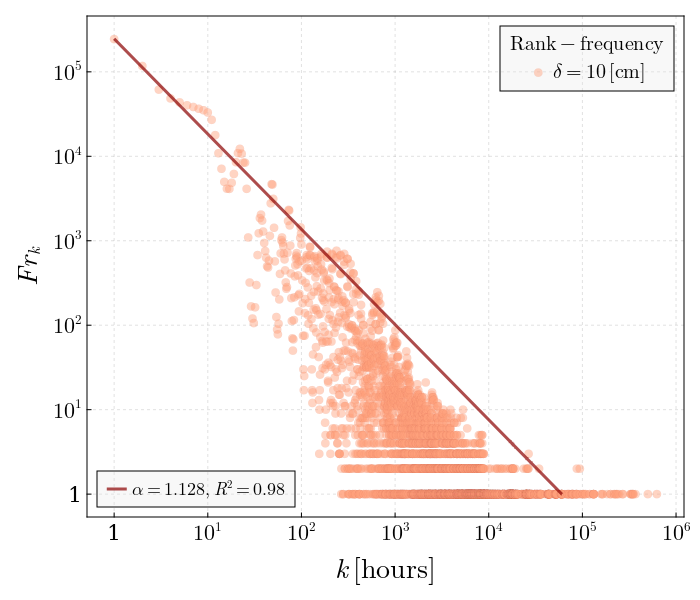

In [14]:
plot_rank_frequency_fit(wt)

## MLE

In [15]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :diamond, :circle, :rect]
colors=[:lightblue, :lightgreen, :lightsalmon, :orchid]
line_colors=[:midnightblue, :green, :darkred, :purple]
i=4

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"k\, \mathrm{[hours]}", ylabel = L"F_k", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)
    
# # CCDF of truncated data (fitted), the plot, (re-normed)
ax2 = Axis(fig, bbox = BBox(150,400,115,330), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
    xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)
    
# Powerlaw fit
fit = powlaw.Fit(wt);
# Round up the data
alpha = round(fit.alpha, digits=2)
sigma = round(fit.sigma, digits=2)
xmin = round(fit.xmin, digits=4)
KS = round(fit.power_law.KS(data=wt), digits=3)


x_ccdf, y_ccdf = fit.ccdf()
########################################### ALL
x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(wt)

sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
color=(colors[1], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)


# The fit (from theoretical power_law)
fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

# Fit through all data
# Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
ln1 = lines!(ax1, x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label = L"\alpha=%$(alpha)\pm %$(sigma),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)",
color=line_colors[1], linewidth=2.5) 


########################################### TRUNCATED
sc2 = scatter!(ax2, x_ccdf, y_ccdf,
color=(colors[1], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=10)


# Fit through truncated data (re-normed)
ln2 = lines!(ax2, x_powlaw, y_powlaw,
color=line_colors[1], linewidth=2.5)


# AXIS LEGEND
axislegend(ax1, [sc1], [L"\delta=%$(delta) \, \mathrm{[cm]}"], position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

ylims!(ax1, 10^(-6.5), 10^(1))


ax1.xticks = ([10^(0),10^(1),10^(2),10^(3) ,10^(4), 10^(5), 10^(6)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}", L"10^{6}"])
ax1.yticks = ([10^(-6), 10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

ax2.xticks = ([10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
ax2.yticks = ([10^(-6), 10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

save("./results_article_plots/wt_$(variable)_delta_$(delta)_bin_mle.png", fig, px_per_unit=7)

fig

xmiCalculating best minimal value for power law fit
xmin progress: 81%

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/anicolin/.julia/packages/PyCall/KLzIO/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'BlockingIOError'>
BlockingIOError(11, 'write could not complete without blocking', 3)
  File "/home/anicolin/.local/lib/python3.10/site-packages/powerlaw.py", line 150, in __init__
    self.find_xmin()
  File "/home/anicolin/.local/lib/python3.10/site-packages/powerlaw.py", line 246, in find_xmin
    fits = asarray(list(map(fit_function, xmins, arange(num_xmins), repeat(num_xmins, num_xmins))))
  File "/home/anicolin/.local/lib/python3.10/site-packages/powerlaw.py", line 230, in fit_function
    print('xmin progress: {:02d}%'.format(int(idx/num_xmins * 100)), end='\r')
